# Color Selection

In [12]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [3]:
# Read in the image and print out some stats
image = mpimg.imread('./test_images/test.jpg')
print('This image is: ',type(image), 
         'with dimensions:', image.shape)

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


In [4]:
image

array([[[122, 185, 229],
        [122, 185, 229],
        [123, 186, 230],
        ..., 
        [123, 184, 229],
        [123, 184, 229],
        [123, 184, 229]],

       [[122, 185, 229],
        [122, 185, 229],
        [122, 185, 229],
        ..., 
        [123, 184, 229],
        [123, 184, 229],
        [123, 184, 229]],

       [[122, 185, 229],
        [122, 185, 229],
        [122, 185, 229],
        ..., 
        [123, 184, 229],
        [123, 184, 229],
        [123, 184, 229]],

       ..., 
       [[154, 166, 154],
        [156, 168, 156],
        [153, 165, 153],
        ..., 
        [180, 197, 181],
        [181, 198, 182],
        [181, 198, 182]],

       [[162, 174, 164],
        [160, 172, 162],
        [152, 164, 154],
        ..., 
        [174, 192, 176],
        [175, 193, 177],
        [176, 194, 178]],

       [[156, 168, 158],
        [148, 160, 150],
        [137, 149, 139],
        ..., 
        [161, 179, 163],
        [162, 180, 164],
        [162, 180,

In [5]:
# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
# Note: always make a copy rather than simply using "="
color_select = np.copy(image)

In [36]:
# Define our color selection criteria
# Note: if you run this code, you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

In [7]:
# Identify pixels below the threshold
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

In [8]:
thresholds

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [9]:
color_select[thresholds]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ..., 
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

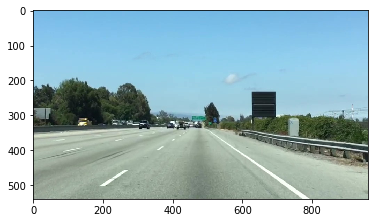

In [10]:
# Display the original image
plt.imshow(image)
plt.show()

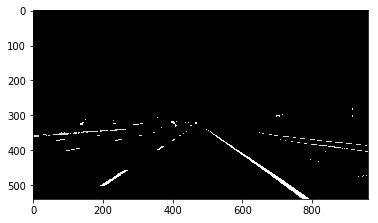

In [11]:
# Display the image                 
plt.imshow(color_select)
plt.show()

---

# Region Masking

At this point, however, it would still be tricky to extract the exact lines automatically, because we still have some other objects detected around the periphery that aren't lane lines.

In this case, I'll assume that the front facing camera that took the image is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image. Next, I'll take advantage of this by adding a criterion to only consider pixels for color selection in the region where we expect to find the lane lines.

Check out the code below. The variables left_bottom, right_bottom, and apex represent the vertices of a triangular region that I would like to retain for my color selection, while masking everything else out. Here I'm using a triangular mask to illustrate the simplest case, but later you'll use a quadrilateral, and in principle, you could use any polygon.

In [12]:
%matplotlib inline

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [15]:
# Read in the image and print some stats
image = mpimg.imread('./test_images/test.jpg')
print('This image is: ', type(image), 
         'with dimensions:', image.shape)

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


In [16]:
# Pull out the x and y sizes and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
region_select = np.copy(image)

In [17]:
# Define a triangle region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
# Note: if you run this code, you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz 
left_bottom = [0, 539]
right_bottom = [900, 300]
apex = [400, 0]

In [18]:
# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

In [19]:
# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

In [20]:
# Color pixels red which are inside the region of interest
region_select[region_thresholds] = [255, 0, 0]

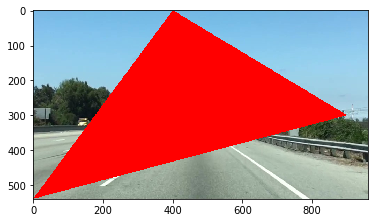

In [21]:
# Display the image
plt.imshow(region_select)

---

# Combining Color and Region Selections

Now you've seen how to mask out a region of interest in an image. Next, let's combine the mask and color selection to pull only the lane lines out of the image.

Check out the code below. Here we’re doing both the color and region selection steps, requiring that a pixel meet both the mask and color selection requirements to be retained.

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [25]:
# Read in the image
image = mpimg.imread('./test_images/test.jpg')

In [26]:
# Grab the x and y sizes and make two copies of the image
# With one copy we'll extract only the pixels that meet our selection,
# then we'll paint those pixels red in the original image to see our selection 
# overlaid on the original.
ysize = image.shape[0]
xsize = image.shape[1]
color_select= np.copy(image)
line_image = np.copy(image)

In [38]:
# Define our color criteria
red_threshold = 20
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

In [39]:
# Define a triangle region of interest (Note: if you run this code, 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
# you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz ;)
left_bottom = [0, 539]
right_bottom = [900, 300]
apex = [400, 0]

In [40]:
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

In [41]:
# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

In [42]:
# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

In [43]:
# Mask color selection
color_select[color_thresholds] = [0,0,0]
# Find where image is both colored right and in the region
line_image[~color_thresholds & region_thresholds] = [255,0,0]

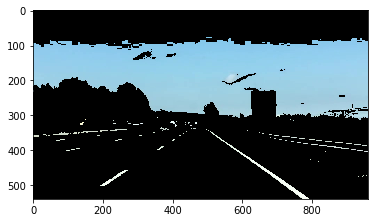

In [44]:
# Display our two output images
plt.imshow(color_select)

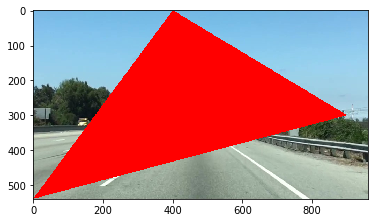

In [45]:
plt.imshow(line_image)

---

# Quiz: Color Region

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


In [53]:
# Read in the image
image = mpimg.imread('./test_images/test.jpg')

In [54]:
# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)

In [55]:
# Define color selection criteria
# MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

In [88]:
# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
# MODIFY THESE VALUES TO ISOLATE THE REGION 
# WHERE THE LANE LINES ARE IN THE IMAGE
left_bottom = [100, 539]
right_bottom = [820, 539]
apex = [450, 300]

In [89]:
# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

In [90]:
# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

In [91]:
# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

In [92]:
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [255, 0, 0]

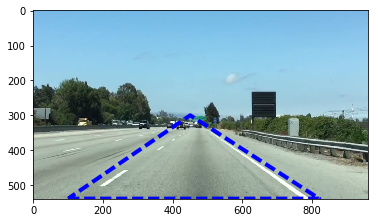

In [95]:
# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)

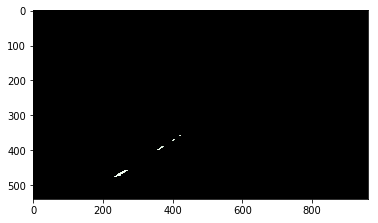

In [96]:
plt.imshow(color_select)

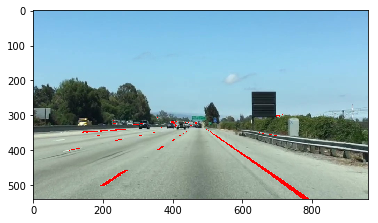

In [97]:
plt.imshow(line_image)

---

# Canny Edge Detection in Action

We expect to find edges where the pixel values are changing rapidly. In this section find the edges of the lane lines in an image of the road

- Algortihm
    - detect strong edge (strong gradient) pixels above the `high_threshold`, and reject pixels below the `low_threshold`. 
    - pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges. 
    - output edges is a binary image with white pixels tracing out the detected edges and black everywhere else.


- What would make sense as a reasonable range for these parameters? In our case, converting to grayscale has left us with an 8-bit image, so each pixel can take 2^8 = 256 possible values. Hence, the pixel values range from 0 to 255.


- This range implies that derivatives (essentially, the value differences from pixel to pixel) will be on the scale of tens or hundreds. So, a reasonable range for your threshold parameters would also be in the tens to hundreds.


- As far as a ratio of low_threshold to high_threshold, John Canny himself recommended a low to high ratio of 1:2 or 1:3.


- We'll also include Gaussian smoothing, before running Canny, which is essentially a way of suppressing noise and spurious gradients by averaging. cv2.Canny() actually applies Gaussian smoothing internally, but we include it here because you can get a different result by applying further smoothing (and it's not a changeable parameter within cv2.Canny()!).


- You can choose the kernel_size for Gaussian smoothing to be any odd number. A larger kernel_size implies averaging, or smoothing, over a larger area. The example in the previous lesson was kernel_size = 3.

In [170]:
#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

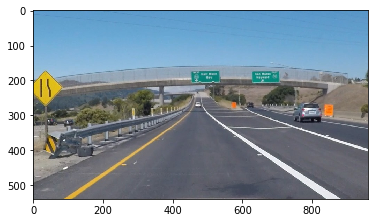

In [184]:
image = mpimg.imread('./test_images/exit-ramp.jpg')
plt.imshow(image)

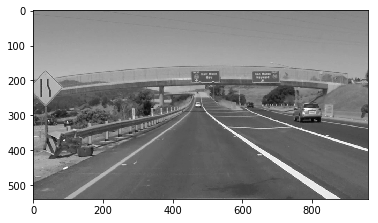

In [185]:
# converting to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')

In [186]:
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

In [187]:
# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

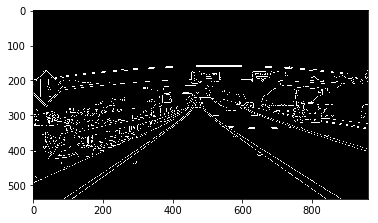

In [188]:
# Display the image
plt.imshow(edges, cmap='Greys_r')

OpenCV function `Canny` on a Gaussian-smoothed grayscaled image called blur_gray and detected edges with thresholds on the gradient of high_threshold, and low_threshold.

---

# Implementing a Hough Transform on Edge Detected Image

Follow this [link](https://alyssaq.github.io/2014/understanding-hough-transform/) for explanation on Hough transformation.

In image space, a line is plotted as x vs. y. In Hough space, "x vs. y" line is represented as a point in "m vs. b" instead. The Hough Transform is just the conversion from image space to Hough space. So, the characterization of a line in image space will be a single point at the position (m, b) in Hough space.

## Algorithm steps

- **Corner or edge detection.** (E.g. using canny, sobel, adaptive thresholding). The resultant binary/grey image will have 0s indicating non-edges and 1s or above indicating edges. This is our input image.

- **Rho range and Theta range creation.** ρ ranges from -max_dist to max_dist where max_dist is the diagonal length of the input image. θ ranges from −90∘ to 90∘. You can have more or less bins in the ranges to tradeoff accuracy, space and speed. E.g. Every third angle  −90∘ to 90∘ to reduce from 180 to 60 values.

- **Hough accumulator of θ vs ρ.** It is a 2D array with the number of rows equal to the number of ρ values and the number of columns equal to the number of θ values.

- **Voting in the accumulator.** For each edge point and for each θ value, find the nearest ρ value and increment that index in the accumulator. Each element tells how many points/pixels contributed “votes” for potential line candidates with parameters (ρ,θ).

- **Peak finding.** Local maxima in the accumulator indicates the parameters of the most prominent lines in the input image. Peaks can be found most easily by applying a threshold or a relative threshold (values equal to or greater than some fixed percentage of the global maximum value).

In [13]:
%matplotlib inline

In [1]:
# Do relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [4]:
# Read in and grayscale the image
image = mpimg.imread('./test_images/exit-ramp.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

In [5]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

In [6]:
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

In [7]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1
line_image = np.copy(image)*0 #creating a blank to draw lines on

In [8]:
# Run Hough on edge detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

In [9]:
# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

In [10]:
# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

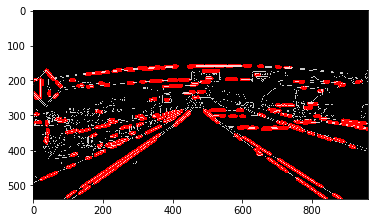

In [14]:
# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)

---

# Quiz: Hough Transform

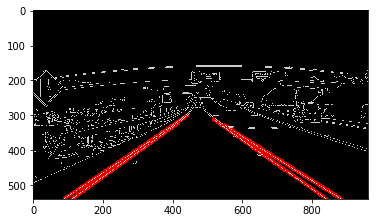

In [81]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


# Read in and grayscale the image
image = mpimg.imread('./test_images/exit-ramp.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(80,imshape[0]),(440, 300), (500, 300), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = (np.pi/180)*0.5 # angular resolution in radians of the Hough grid
threshold = 100    # minimum number of votes (intersections in Hough grid cell)
min_line_length = 1 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 0.9, 0) 
plt.imshow(lines_edges)